## **Adversarial Example on a Classifier**

#### **Tricking a classifier**

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.models import resnet18
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
def generate(model: nn.Module, input: torch.Tensor, target_class: int, num_steps: int = 10) -> torch.Tensor:
    alpha = 0.025
    epsilon = 0.25
    loss_fn = nn.CrossEntropyLoss()

    x_adv = input.clone().detach().requires_grad_(True)

    for _ in range(num_steps):
        model.zero_grad()

        output = model(x_adv)
        target = torch.tensor([target_class], dtype=torch.long)
        loss = loss_fn(output, target)
        loss.backward()

        # Gradient sign step
        with torch.no_grad():
            perturbation = alpha * torch.sign(x_adv.grad)
            x_adv = x_adv + perturbation  # move toward increasing target class therefore adding perturation cause I want to increase the loss.
            x_adv = torch.clamp(x_adv, input - epsilon, input + epsilon)

        x_adv.requires_grad_(True)  # reattach for next step

    return x_adv

In [30]:
# Load a pretrained model
model = resnet18(pretrained=True)
model.eval()

# Load and preprocess an image
image = Image.open('clown_fish.jpg').convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Converts to [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Target class index (e.g., dog = 207)
target_class = 407


# Generate adversarial image
adv_tensor = generate(model, input_tensor, target_class, num_steps=50)

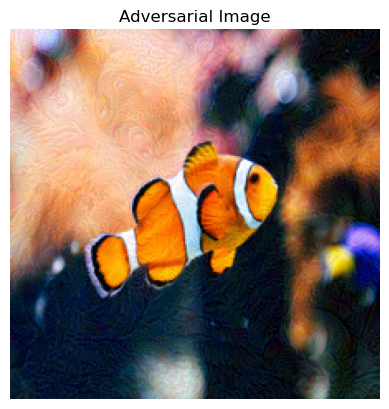

In [32]:
# De-normalize and convert to image for visualization
unnormalize = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
    std=[1/s for s in [0.229, 0.224, 0.225]]
)

adv_image = unnormalize(adv_tensor.squeeze()).clamp(0, 1)
plt.imshow(adv_image.permute(1, 2, 0).detach().cpu().numpy())
plt.title("Adversarial Image")
plt.axis("off")
plt.show()

In [35]:
output = model(adv_tensor)
pred_class = output.argmax(dim=1).item()
print(f"Predicted class for adversarial image: {pred_class}")

Predicted class for adversarial image: 393
